# Evaluación de Resultados
En este notebook se muestra técnicas para la evaluación de resultados de una predcción con un algoritmo de Machine Learning.

# Imports

In [1]:
# Manipulación de archivos ARFF
import arff
import pandas as pd
import numpy as np
# División del conjunto de datos
from sklearn.model_selection import train_test_split
# Escalado de Datos
from sklearn.preprocessing import RobustScaler
# Codificar variables Categoricas
from sklearn.preprocessing import OneHotEncoder
# Rellenar el valor de un ejemplar con un estrategia
from sklearn.impute import SimpleImputer
# Crear Pipelines Personalizados (agrupar flujo de tranformaciones)
from sklearn.pipeline import Pipeline
# Componentes de un Tranformador: Estimador .:. fit() y Tranformador .:. tranform()
from sklearn.base import BaseEstimator, TransformerMixin
# Ejecutar Pipelines en paralelo, contatenendo resultado
from sklearn.compose import ColumnTransformer

# Funciones Auxiliares

## Lector del DataSet

In [2]:
def load_kdd_dataset(data_path):
    with open(data_path, 'r') as train_set:
        dataset = arff.load(train_set)
    attributes = [attr[0] for attr in dataset['attributes']]
    return pd.DataFrame(dataset['data'], columns=attributes)

## Divisor de DataSet

In [3]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratiify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

## Pipeline de Atributos Numéricos
Flujo de trabajo de tranformadores 
1. Rellenamos NaNS
2. Escalamos datos

In [4]:
# Construccion de Pipeline
num_pipeline = Pipeline([
    # 1er. Proceso de tranform()
    ('imputer', SimpleImputer(strategy='median')),
    # 2do. Proceso de transform()
    ('rbst_scaler', RobustScaler()),
])

### Transfomador Codificador de Columnas Categoricas
Devuelve un DataFrame

In [5]:
# Creamos la clase con el transformador
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Instanciamos OHE
        self._oh = OneHotEncoder(sparse=False)
        # Creamos el objeto columnas vacio que usaremos despues
        self._columns = None
    def fit(self, X, y=None):
        # Creamos el objeto con las categorias 
        X_cat = X.select_dtypes(include=['object'])
        # Al objeto vacio le asignamos las columnas que de como resultado aplicar "get_dummies" a "x_cat"
        # Se obtiene una columna diferente por cada valor en la columna, los nombre se asignan al objeto
        self._columns = pd.get_dummies(X_cat).columns
        # Se aplica OHE sobre "x_cat"
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        # Se asignas columnas categoricas
        X_cat = X_copy.select_dtypes(include=['object'])
        # Se asignas columnas con valores numericos
        X_num = X_copy.select_dtypes(exclude=['object'])
        # Se codifica x_cat (columnas con categorias)
        X_cat_oh = self._oh.transform(X_cat)
        # --------------------------------------------------
        # Se crea un DF con las columnas categoricas codificadas
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                # El nombre de las columnas
                               columns=self._columns,
                                # El indice de DS original
                               index=X_copy.index)
        # -----------------------------------------------------
        # Del DF original se elimina x_cat
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        # Se retorna la union del DF original y el nuevo con las columnas codificadas
        return X_copy.join(X_cat_oh)

### Transformador que prepara todo el conjunto de datos llamando pipelines y tranformadores personalizados

In [6]:
class DataFramePreparer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Creamos objetos que usaremos en todo el trnagformador
        self._full_pipeline = None
        self._columns = None
    def fit(self, X, y=None):
        # Separamos con objetos los tipos de categorias
        num_attribs = list(X.select_dtypes(exclude=['object']))
        cat_attribs = list(X.select_dtypes(include=['object']))
        # --------------------------------------
        # Instanciamos el Ejecutar de los Pipelines
        self._full_pipeline = ColumnTransformer([
            # nombre, pipeline o transformador, datos a usar 
            ("num", num_pipeline, num_attribs),
            ("cat", CustomOneHotEncoder(), cat_attribs),
        ])
        # --------------------------------------
        # Sobre el DS que pasemos en X aplicaremos el ejecutador de pipelines
        self._full_pipeline.fit(X)
        # Asignamos las columnas que de como resultado aplicar "get_dummies" a "x_cat"
        # Se obtiene una columna diferente por cada columna, los nombre se asignan al objeto
        self._columns = pd.get_dummies(X).columns
        # Se usa "return self"usa para continuar con el flujo
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_prep = self._full_pipeline.transform(X_copy)
        return pd.DataFrame(X_prep, 
                            columns=self._columns, 
                            index=X_copy.index)

# Procesamiento de DataSet

## Lectura del conjunto de datos

In [7]:
df = load_kdd_dataset('KDDTrain+.arff')

In [8]:
df.head(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
5,0.0,tcp,private,REJ,0.0,0.0,0,0.0,0.0,0.0,...,19.0,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
6,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,9.0,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
7,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,15.0,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
8,0.0,tcp,remote_job,S0,0.0,0.0,0,0.0,0.0,0.0,...,23.0,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
9,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,13.0,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


## División del Conjunto de datos

In [9]:
train_set, val_set, test_set = train_val_test_split(df)

In [10]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 75583
Longitud del Validation Set: 25195
Longitud del Test Set: 25195


### Separamos categorias de etiquetas en cada conjunto de datos
Para cada uno de los subconjuntos, separamos las etiquetas de las características de entrada.

In [11]:
# Conjunto de datos general
X_df = df.drop("class", axis=1)
y_df = df['class'].copy()

In [12]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("class", axis=1)
y_train = train_set["class"].copy()

In [13]:
# Conjunto de datos de validación
X_val = val_set.drop('class', axis=1)
y_val = val_set['class'].copy()

In [14]:
# Conjunto de datos de pruebas
X_test = test_set.drop('class', axis=1)
y_test = test_set['class'].copy()

## Preparación del conjunto de datos

In [15]:
# Intanciamos nuestro tranformador personalizado
data_preparer = DataFramePreparer()

In [24]:
# Hacemos el fit con el conjunto de datos general para que adquiera todos los valores posibles
data_preparer.fit(X_df)

DataFramePreparer()

En "DataFramePreparer" .:. rellenamos nulos, escalamos y codificamos los datos

In [17]:
# Transformamos el subconjunto de datos de entrenamiento
X_train_prep = data_preparer.transform(X_train)
X_train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
98320,0.0,icmp,ecr_i,SF,1032.0,0.0,0,0.0,0.0,0.0,...,210.0,65.0,0.31,0.01,0.31,0.00,0.0,0.0,0.0,0.0
8590,0.0,tcp,smtp,SF,1762.0,331.0,0,0.0,0.0,0.0,...,30.0,122.0,0.73,0.07,0.03,0.02,0.0,0.0,0.0,0.0
91385,0.0,icmp,eco_i,SF,8.0,0.0,0,0.0,0.0,0.0,...,2.0,126.0,1.00,0.00,1.00,0.25,0.0,0.0,0.0,0.0
54349,0.0,tcp,csnet_ns,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,18.0,0.07,0.07,0.00,0.00,1.0,1.0,0.0,0.0
69568,0.0,tcp,smtp,SF,1518.0,342.0,0,0.0,0.0,0.0,...,83.0,125.0,0.66,0.05,0.01,0.02,0.0,0.0,0.0,0.0


In [18]:
# Transformamos el subconjunto de datos de validación
X_val_prep = data_preparer.transform(X_val)
X_val_prep.head(5)

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_SF,flag_SH,land_0,land_1,logged_in_0,logged_in_1,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
115297,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7438,0.0,0.992754,5.844961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
52597,5.0,8.079710,0.647287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
10161,0.0,0.898551,3.189922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
120044,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


## Entrenamiento de un algoritmo de Regresión Logística
La instalación de un algoritmo de Machine Learning utilizando Sklearn se realiza utilizando los metodos expuestos por la API de sklearn tal y como se ha presentado en cuadernos anteriores.

In [19]:
# Entrenamos un algoritmo basado en regresión logística
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_prep, y_train)

C:\Users\Martin Farrera\anaconda3\envs\curso_deep_learning\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=5000)

# Predicción de nuevos ejemplares 
Realizamos una predcción con el modelo generado anteriormente tras el entrenamiento del Algoritmo de Regresión Logistica. Utilizamos el subconjunto de validación.

In [20]:
y_pred = clf.predict(X_val_prep)

# Matriz de Confunción

In [22]:
from sklearn.metrics import confusion_matrix

# (datos que quedarona apartados y datos que acabamos de preparar)
confusion_matrix(y_val, y_pred)

array([[11430,   444],
       [  256, 13065]], dtype=int64)

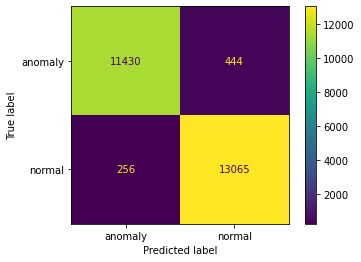

In [23]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val_prep, y_val, values_format='3g')

# Metricas Derivadas de la Matriz de Confusión

## Preción

In [37]:
from sklearn.metrics import precision_score
print("Precisión:", precision_score(y_val, y_pred, pos_label='anomaly'))

0.4654784564803599

## Recall

In [28]:
from sklearn.metrics import recall_score

print("Recall:", recall_score(y_val, y_pred, pos_label='anomaly'))

Recall: 0.9626073774633653


## F1 Score

In [29]:
from sklearn.metrics import f1_score

print("F1 score:", f1_score(y_val, y_pred, pos_label='anomaly'))

F1 score: 0.9702886247877759


# Curvas ROC y PR

## Curva Roc

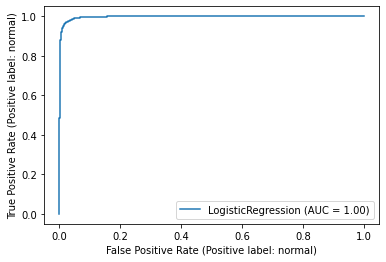

In [30]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf, X_val_prep, y_val)

## Curva PR

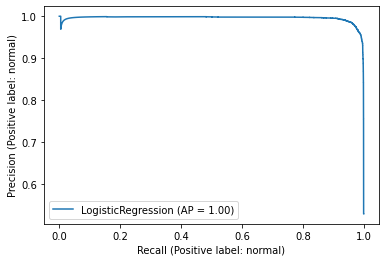

In [31]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(clf, X_val_prep, y_val)

# Evalución del modelo con el conjunto de datos de pruebas

In [32]:
# Transformamos el subconjunto de datos de validacion (test)
X_test_prep = data_preparer.transform(X_test)

In [33]:
# Pasamos por la Predicción de la Regresion Logistica
y_pred = clf.predict(X_test_prep)

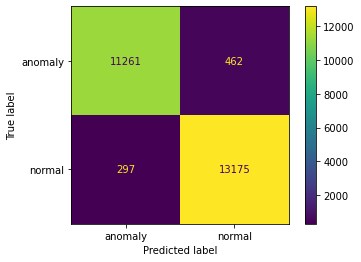

In [35]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test_prep, y_test, values_format='3g')

In [36]:
print("F1 Score", f1_score(y_test, y_pred, pos_label="anomaly"))

F1 Score 0.9673983076328337
